C:\Users\SAULO\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Progress: 100.0% completed

Melhor alocação encontrada:
   Legislative  Judiciary  Essential to Justice  Administration  \
0    -0.310226  -0.442114              0.234047       -0.066964   

   National Defense  Public Safety  Foreign Relations  Social Assistance  \
0         -0.322303       0.020994           0.161943          -0.326185   

   Security    Health  ...  Agriculture  Agrarian Organization  Industry  \
0 -0.390133  0.353469  ...    -0.310356              -0.153765  -0.79808   

   Services and Commerce  Communications    Energy  Transportation  \
0              -0.487765       -1.013957 -1.221981         0.36183   

   Sports and Leisure  Special Charges  Refinancing  
0           -0.869041         0.128939    -0.184647  

[1 rows x 29 columns]

Resultados com a melhor alocação:
Crescimento do PIB: 1.5649843215942383
Inflação: -1.2761694192886353
Índice de Gini: -0.3030845820903778


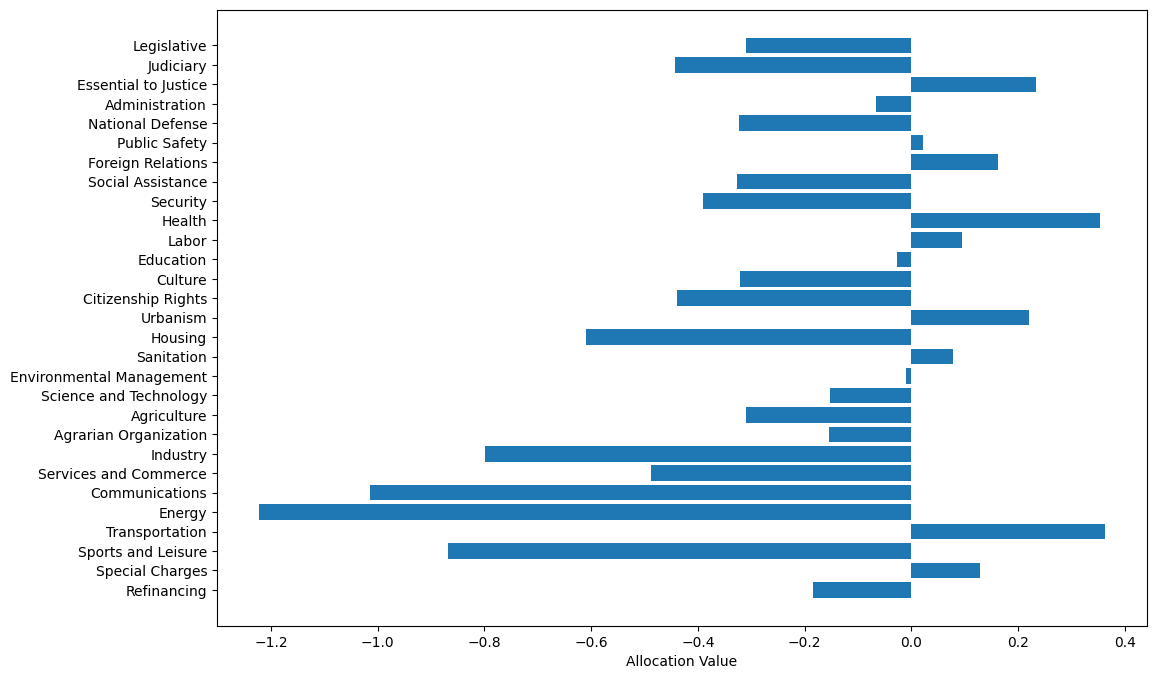

In [1]:
# optimization.py
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import joblib
import optuna
import matplotlib.pyplot as plt

# Cria a pasta "graphs" para salvar os gráficos, se não existir.
os.makedirs("graphs", exist_ok=True)

# Configura o nível de log do Optuna para reduzir as mensagens.
optuna.logging.set_verbosity(optuna.logging.WARNING)

def load_model(path='saved_model.pkl'):
    """Carrega o modelo treinado a partir do arquivo especificado."""
    return joblib.load(path)

def load_augmented_data(path='augmented_dataset.csv'):
    """
    Carrega o conjunto aumentado e extrai as 29 variáveis de entrada.
    
    Retorna:
        X_augmented (DataFrame): Dados de entrada (29 colunas).
    """
    augmented_data = pd.read_csv(path)
    X_augmented = augmented_data.iloc[:, :-3]
    return X_augmented

def define_bounds(X_augmented, factor=1.0):
    """
    Define o baseline (mediana) e os limites para cada variável de entrada.
    
    Cada limite é definido como: baseline ± (factor * desvio padrão).
    
    Retorna:
        baseline_dict (dict): Baseline para cada variável.
        bounds (dict): Intervalos de valores para cada variável.
    """
    baseline_series = X_augmented.median()
    std_series = X_augmented.std()
    bounds = {}
    for col in X_augmented.columns:
        bounds[col] = (baseline_series[col] - factor * std_series[col],
                       baseline_series[col] + factor * std_series[col])
    baseline_dict = baseline_series.to_dict()
    return baseline_dict, bounds

def objective(trial, model, baseline_dict, bounds, lambda_reg=0.5):
    """
    Sugere valores para cada variável de entrada, calcula uma penalidade com base
    no desvio do baseline e retorna o score definido como:
        (crescimento do PIB - inflação - índice de Gini) - penalidade.
    """
    suggested_allocation = {}
    for col, (low, high) in bounds.items():
        suggested_allocation[col] = trial.suggest_float(col, low, high)
    penalty = lambda_reg * sum(abs(suggested_allocation[col] - baseline_dict[col]) 
                               for col in baseline_dict)
    input_df = pd.DataFrame([suggested_allocation])
    y_pred = model.predict(input_df)
    gdp_growth, inflation, gini_index = y_pred[0]
    score = gdp_growth - inflation - gini_index - penalty
    return score

def progress_callback(n_trials):
    """
    Retorna uma função callback que exibe o progresso percentual da otimização.
    """
    def callback(study, trial):
        completed = len(study.trials)
        progress = (completed / n_trials) * 100
        print(f"Progress: {progress:.1f}% completed", end="\r")
    return callback

def optimize_allocation(model, baseline_dict, bounds, n_trials=1000, lambda_reg=0.5):
    """
    Executa a otimização com Optuna usando o callback de progresso.
    
    Retorna:
        study (Study): Objeto de estudo com os resultados da otimização.
    """
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective(trial, model, baseline_dict, bounds, lambda_reg),
                   n_trials=n_trials,
                   callbacks=[progress_callback(n_trials)])
    print()  # Nova linha após o progresso.
    return study

def plot_best_allocation(best_allocation_df):
    """
    Gera e salva um gráfico de barras horizontal que exibe a melhor alocação.
    """
    plt.figure(figsize=(12, 8))
    plt.barh(best_allocation_df.columns, best_allocation_df.iloc[0])
    plt.xlabel("Allocation Value")
    plt.gca().invert_yaxis()
    plt.savefig("graphs/optimized_allocation.png")
    plt.show()

def main():
    # Carrega o modelo treinado e os dados aumentados.
    model = load_model()
    X_augmented = load_augmented_data()
    
    # Define o baseline e os limites com base nos dados aumentados.
    baseline_dict, bounds = define_bounds(X_augmented, factor=1.0)
    
    # Executa a otimização.
    n_trials = 1000
    study = optimize_allocation(model, baseline_dict, bounds, n_trials=n_trials, lambda_reg=0.5)
    best_params = study.best_trial.params
    
    # Constrói a melhor alocação com os parâmetros otimizados.
    best_allocation_df = pd.DataFrame([best_params])
    print("\nMelhor alocação encontrada:")
    print(best_allocation_df)
    best_allocation_df.to_csv('best_allocation.csv', index=False)
    
    # Avalia os resultados da melhor alocação.
    best_allocation_results = model.predict(best_allocation_df)
    print("\nResultados com a melhor alocação:")
    print(f"Crescimento do PIB: {best_allocation_results[0][0]}")
    print(f"Inflação: {best_allocation_results[0][1]}")
    print(f"Índice de Gini: {best_allocation_results[0][2]}")
    
    # Gera e salva o gráfico da melhor alocação.
    plot_best_allocation(best_allocation_df)

if __name__ == "__main__":
    main()

